# Abalone DataSet - Predict Sex

# 1 Load and store initial Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pd.options.mode.chained_assignment = None  # default='warn'

color = sns.color_palette()

#Load the dataset
df = pd.read_csv("abalone.data.txt", sep=",", header = None)

#Insert Column-Names
df.columns = ["Sex", "Length", "Diameter", "Height", "Whole_weight", "Shucked_weight",
              "Viscera_weight", "Shell_weight", "Rings"]
df.head()


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# 2 Exploration of Data

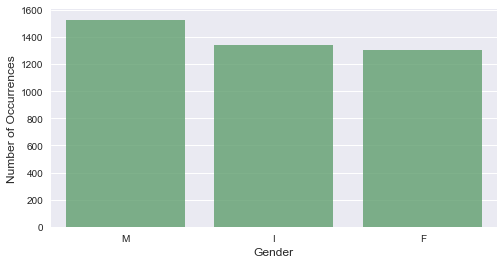

In [3]:
sex_level = df['Sex'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(sex_level.index, sex_level.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [4]:
sex_level.values[0] / (sex_level.values[0]+sex_level.values[1]+sex_level.values[2] )

0.36581278429494851

Approx 36,58% Male population. Minimum accuracy for M-Predictions.

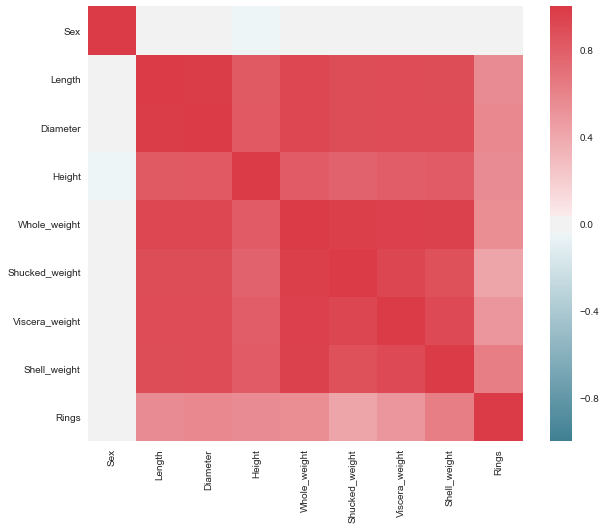

In [5]:
df["Sex"] = df["Sex"].astype('category')
df["Sex"] = df["Sex"].cat.codes.ravel()


f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Observations :

- The target variable is not correlated at all with the given features
- Very strong correlations - PCA use-case? 

In [6]:
corr 

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Sex,1.000000,-0.036066,-0.038874,-0.042077,-0.021391,-0.001373,-0.032067,-0.034854,-0.034627
Length,-0.036066,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,-0.038874,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,-0.042077,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,-0.021391,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,-0.001373,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,-0.032067,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,-0.034854,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,-0.034627,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


## Logical checks 

In [7]:
errors = []

for index, row in df.iterrows():
    
    #Impossible cases
    if row['Whole_weight'] < row['Shucked_weight'] + row['Shell_weight']:
         errors.append(index)
    if row['Whole_weight'] < row['Shucked_weight']:
        errors.append(index)
    if row['Whole_weight'] < row['Viscera_weight']:
        errors.append(index)
    if row['Whole_weight'] < row['Shell_weight']:
        errors.append(index)
    if row['Shucked_weight'] < row['Viscera_weight']:
        errors.append(index)
        
#delete duplicates
errors  = list(set(errors))

#Delete rows with failed measurements
for e in errors:
    df = df.drop(df.index[e])
    
print( "Deleted: " + str(np.size(errors)) + "Errors" +"\n"+ "DataSet has now " + str(np.shape(df)[0]) + "rows")

Deleted: 19Errors
DataSet has now 4158rows


# 3 Distribution of features - Smooth outliners
## Rings

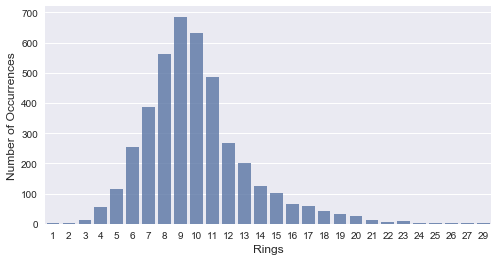

In [8]:
cnt_rings = df['Rings'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_rings.index, cnt_rings.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Rings', fontsize=12)
plt.show()

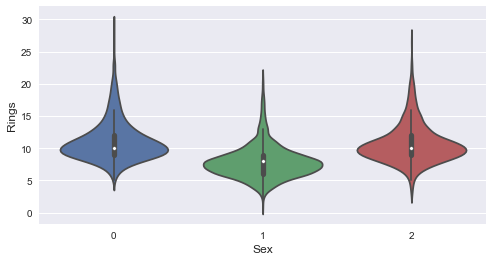

In [9]:
plt.figure(figsize=(8,4))
sns.violinplot(x='Sex', y='Rings', data=df)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Rings', fontsize=12)
plt.show()

## Length

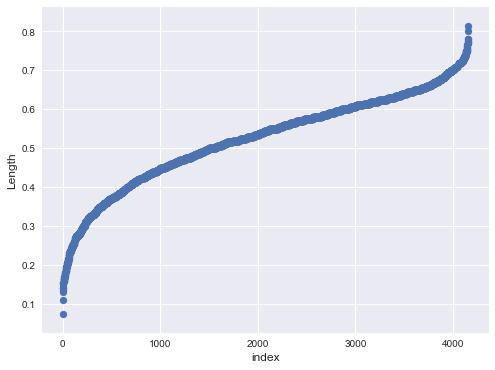

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Length.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.show()

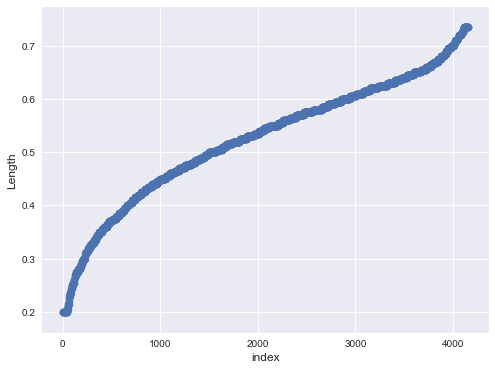

In [17]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Length.values, 99)
df['Length'].ix[df['Length']>maxLimit] = maxLimit

minLimit = np.percentile(df.Length.values, 1)
df['Length'].ix[df['Length']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Length.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.show()

## Diameter

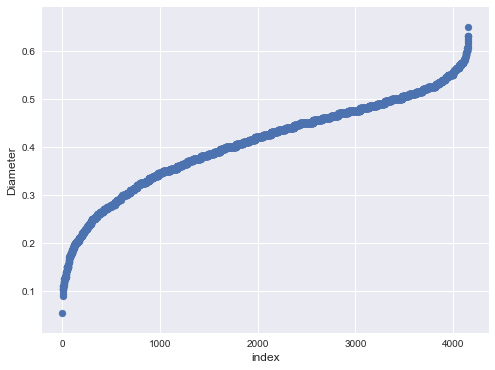

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Diameter.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Diameter', fontsize=12)
plt.show()

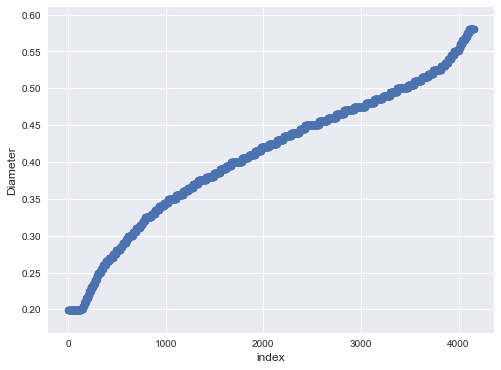

In [16]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Diameter.values, 99)
df['Diameter'].ix[df['Diameter']>maxLimit] = maxLimit

minLimit = np.percentile(df.Length.values, 1)
df['Diameter'].ix[df['Diameter']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Diameter.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Diameter', fontsize=12)
plt.show()

## Height

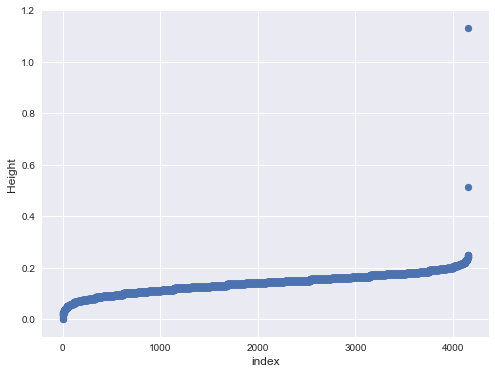

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Height.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Height', fontsize=12)
plt.show()

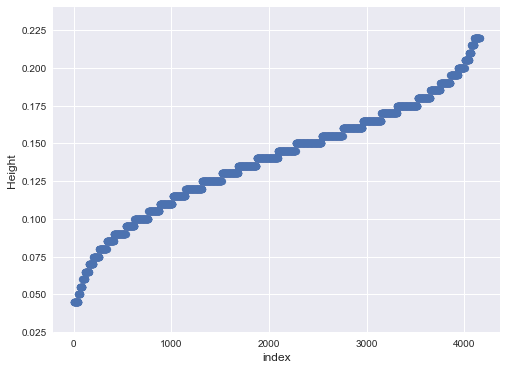

In [18]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Height.values, 99)
df['Height'].ix[df['Height']>maxLimit] = maxLimit

minLimit = np.percentile(df.Height.values, 1)
df['Height'].ix[df['Height']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Height.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Height', fontsize=12)
plt.show()

## Whole weight

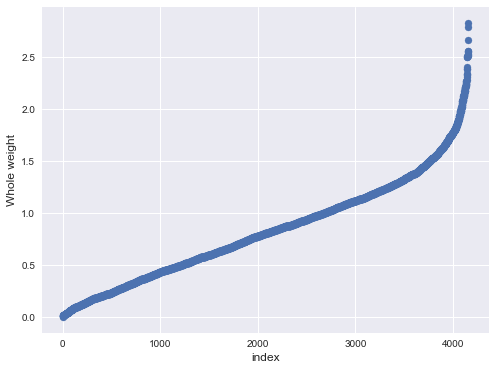

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Whole_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Whole weight', fontsize=12)
plt.show()

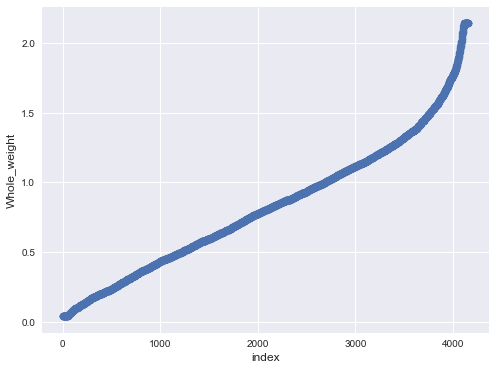

In [19]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Whole_weight.values, 99)
df['Whole_weight'].ix[df['Whole_weight']>maxLimit] = maxLimit

minLimit = np.percentile(df.Whole_weight.values, 1)
df['Whole_weight'].ix[df['Whole_weight']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Whole_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Whole_weight', fontsize=12)
plt.show()

/Users/mluchtmeyer/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


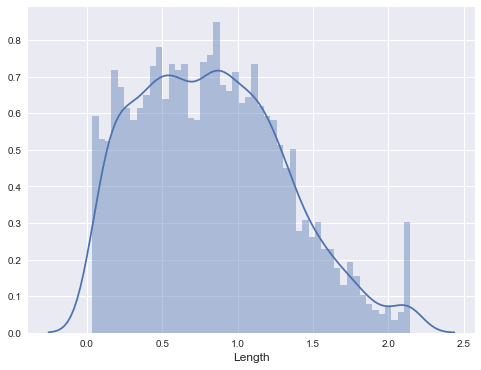

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(df.Whole_weight.values, bins=50, kde=True)
plt.xlabel('Length', fontsize=12)
plt.show()

## Shucked_weight

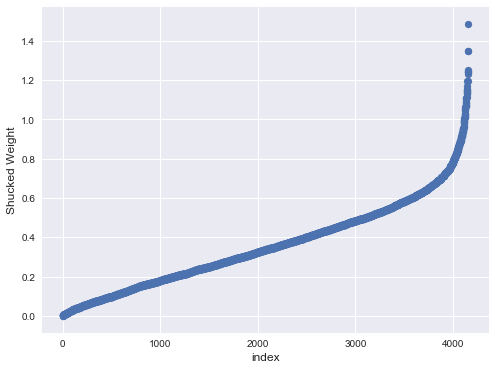

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Shucked_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Shucked Weight', fontsize=12)
plt.show()

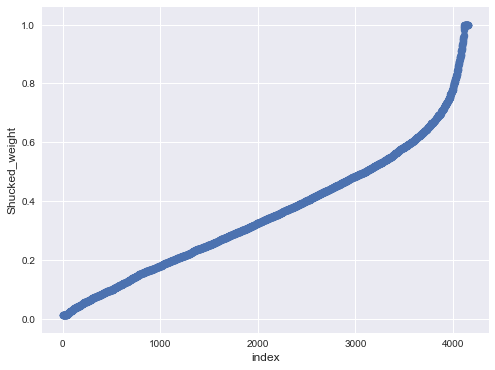

In [20]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Shucked_weight.values, 99)
df['Shucked_weight'].ix[df['Shucked_weight']>maxLimit] = maxLimit

minLimit = np.percentile(df.Shucked_weight.values, 1)
df['Shucked_weight'].ix[df['Shucked_weight']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Shucked_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Shucked_weight', fontsize=12)
plt.show()

## Viscera_weight

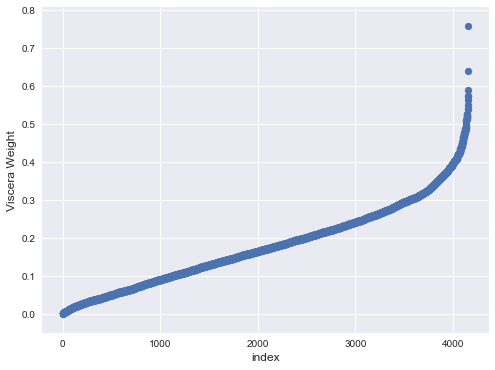

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Viscera_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Viscera Weight', fontsize=12)
plt.show()

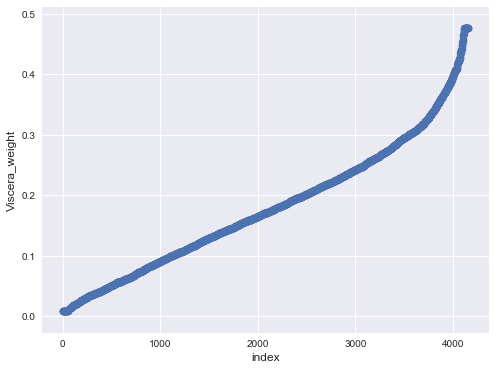

In [21]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Viscera_weight.values, 99)
df['Viscera_weight'].ix[df['Viscera_weight']>maxLimit] = maxLimit

minLimit = np.percentile(df.Viscera_weight.values, 1)
df['Viscera_weight'].ix[df['Viscera_weight']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Viscera_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Viscera_weight', fontsize=12)
plt.show()

## Shell Weight

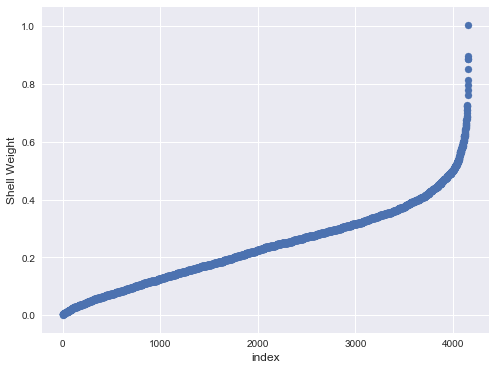

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Shell_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Shell Weight', fontsize=12)
plt.show()

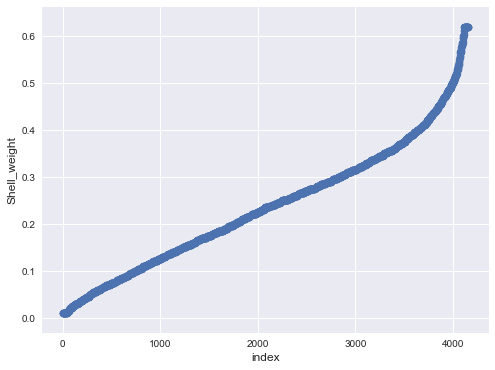

In [22]:
#Smooth down/up the outliners

maxLimit = np.percentile(df.Shell_weight.values, 99)
df['Shell_weight'].ix[df['Shell_weight']>maxLimit] = maxLimit

minLimit = np.percentile(df.Shell_weight.values, 1)
df['Shell_weight'].ix[df['Shell_weight']<minLimit] = minLimit

plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.Shell_weight.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Shell_weight', fontsize=12)
plt.show()

# 4 Prepare Data for analysis

In [23]:
#Split Data / Target
df_data = df.ix[:, df.columns != "Sex"]
df_target = df.ix[:, df.columns == "Sex"]

#Mark Target as categorial 
#Ecnode categorial to numeric representation
df_target["Sex"] = df_target["Sex"].astype('category')
df_target = df_target["Sex"].cat.codes.ravel()
df_target

## M = 2 , I = 1 , F = 0 


#Check
print(df_data.Height.mean())
print(df_data.Height.std())

# The Labels are not equality distributed. Therefore, a Stratified-KFold is used to ensure
# That every fold has the same representation of labels
skf = StratifiedKFold(n_splits=2)
train_index , test_index = skf.split(df_data, df_target)


X_train, X_test = df_data.iloc[train_index[0]], df_data.iloc[test_index[0]]
y_train, y_test = df_target[test_index[1]], df_target[train_index[1]]


#Check if the labels are equally repsented in the given Folds
values, counts = np.unique(y_train, return_counts=True)
print(values, counts)

values, counts = np.unique(y_test, return_counts=True)
print(values, counts)

0.13938792688792606
0.03787813052639446
[0 1 2] [653 664 761]
[0 1 2] [654 665 761]


# First try

In [104]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print('Train Score')
print(clf.score(X_train, y_train) ) 
print('Test Score')
print(clf.score(X_test, y_test) )


Train Score
0.547641963426
Test Score
0.539903846154


# 5 Parameter tuning

In [26]:
from sklearn.grid_search import GridSearchCV

#new rfc
rfc = RandomForestClassifier()

# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(rfc, param_grid = {parameter: num_range})
    grid_search.fit(df_data, df_target)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

/Users/mluchtmeyer/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluchtmeyer/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [27]:
# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(2, 300, 2),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

In [28]:
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1


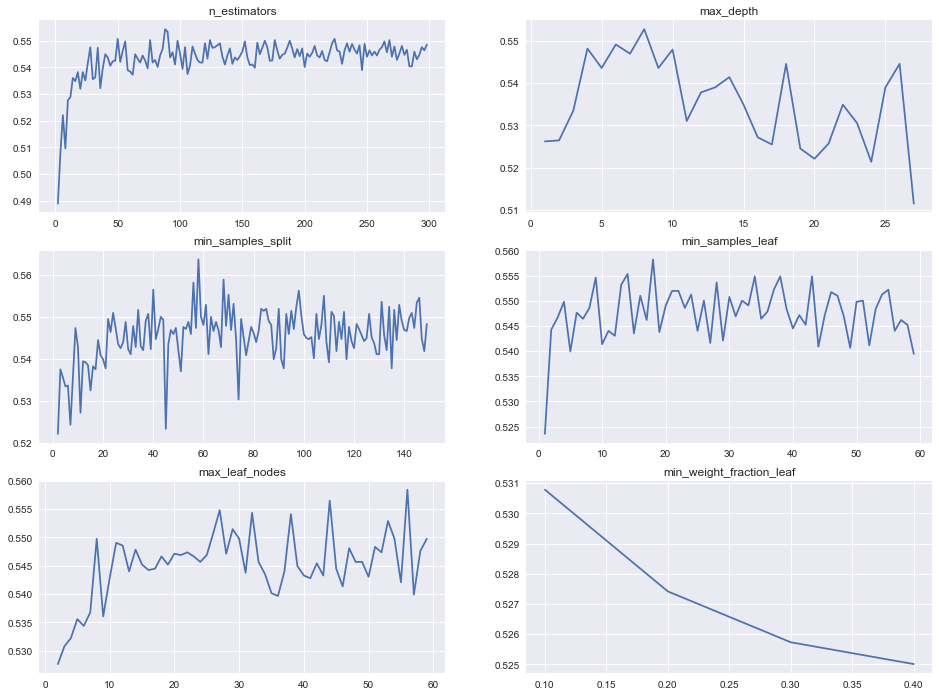

In [29]:
plt.show()

In [84]:
from sklearn.metrics import confusion_matrix
rfc = RandomForestClassifier(n_estimators=75, max_depth=7,
     min_samples_split=59, random_state=0)

rfc.fit(X_train, y_train)

yPred = rfc.predict(X_test)

confusion_matrix(y_test , yPred, labels=[0, 1, 2])
rfc.score(X_test, y_test)

0.55144230769230773

# 6 PCA
Since parameter tuning seems to be not promising. 

(Length+Diameter+Height) = Size
          (Weights)      = Weight 
          
could be clustered to PC's  

In [109]:
from sklearn.preprocessing import StandardScaler

#Standardizing
#Normalize to mean 0 and std 1
# All predictors should have the same a priori importance 

X_std = StandardScaler().fit_transform(X_train)

In [110]:
#Covariance Matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)

In [111]:
#Eigendecomposition
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[  3.69238725e-01  -7.63810274e-02  -4.57525475e-01   4.02355540e-01
    6.89643062e-01   2.15734272e-02   1.02284148e-01  -8.61100313e-03]
 [  3.70610073e-01  -6.29615546e-02  -4.27093541e-01   3.75254389e-01
   -7.19540619e-01   3.14001759e-03   8.77505677e-02   1.00052704e-01]
 [  3.59783083e-01   7.70753389e-02  -4.43984991e-01  -7.71919410e-01
   -9.43724747e-03   5.81920539e-03  -1.47112670e-01  -2.23311922e-01]
 [  3.74976403e-01  -1.30981479e-01   3.26861720e-01  -1.24991243e-02
    5.97061101e-04   8.47601056e-01  -1.18585288e-01   5.24534078e-02]
 [  3.59983661e-01  -2.90964928e-01   3.11720932e-01   1.64948871e-01
   -9.65818728e-03  -3.94440494e-01  -6.47702111e-01  -2.93561742e-01]
 [  3.65527121e-01  -1.67201707e-01   3.65400130e-01  -9.01083212e-02
   -2.44143871e-02  -2.06238087e-01   7.22022325e-01  -3.63799808e-01]
 [  3.69011108e-01   5.04716181e-02   2.11992024e-01  -1.94337380e-01
    7.65974425e-02  -2.86983481e-01   3.22818550e-02   8.30245131e-01]

In [112]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [113]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
6.86272127935
0.703799586323
0.160893191673
0.119509413613
0.0750134099735
0.0598096621761
0.0148636431756
0.00724152291196


In [114]:
#Explained Variance
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [115]:
var_exp

[85.742733982257406,
 8.793261193407508,
 2.0101970591052876,
 1.4931487732991939,
 0.93721638904624605,
 0.74726099819378333,
 0.1857061289438002,
 0.09047547574677052]

In [116]:
var_exp[0]+ var_exp[1]+ var_exp[2]

96.546192234770189

96,546% explained variance with the first 3 components should be alright.

In [117]:
#Projektion matrix

matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1),
                      eig_pairs[1][1].reshape(8,1),
                      eig_pairs[2][1].reshape(8,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.36923873 -0.07638103 -0.45752548]
 [ 0.37061007 -0.06296155 -0.42709354]
 [ 0.35978308  0.07707534 -0.44398499]
 [ 0.3749764  -0.13098148  0.32686172]
 [ 0.35998366 -0.29096493  0.31172093]
 [ 0.36552712 -0.16720171  0.36540013]
 [ 0.36901111  0.05047162  0.21199202]
 [ 0.23852098  0.92300631  0.16932949]]


In [118]:
Y = X_std.dot(matrix_w)

In [119]:
np.shape(Y)

(2078, 3)

In [123]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, max_depth=None,
     min_samples_split=2, random_state=0)
                         

rfc.fit(Y, y_train)
print("Train Score")
rfc.score(Y, y_train)

Train Score


0.97449470644850822

In [122]:
#Confusion Matrix

yPred = rfc.predict(Y)
confusion_matrix(y_train , yPred)

array([[638,   8,   7],
       [  3, 658,   3],
       [ 19,  13, 729]])

In [99]:
from sklearn.decomposition import PCA as sklearnPCA


#Fast check for test score
sklearn_pca = sklearnPCA(n_components=3)
X_std = StandardScaler().fit_transform(X_test)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [101]:
rfc.score(Y_sklearn, y_test)

0.51682692307692313